# Display Some Images

In [1]:
import os
# import shutil
# import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import functools
%matplotlib inline

First we straighten ou images. Thanks to [Roman Odaisky](https://stackoverflow.com/users/21055/roman-odaisky)

In [2]:

def image_transpose_exif(im):
    """
    Apply Image.transpose to ensure 0th row of pixels is at the visual
    top of the image, and 0th column is the visual left-hand side.
    Return the original image if unable to determine the orientation.

    As per CIPA DC-008-2012, the orientation field contains an integer,
    1 through 8. Other values are reserved.

    Parameters
    ----------
    im: PIL.Image
       The image to be rotated.
    """

    exif_orientation_tag = 0x0112
    exif_transpose_sequences = [                   # Val  0th row  0th col
        [],                                        #  0    (reserved)
        [],                                        #  1   top      left
        [Image.FLIP_LEFT_RIGHT],                   #  2   top      right
        [Image.ROTATE_180],                        #  3   bottom   right
        [Image.FLIP_TOP_BOTTOM],                   #  4   bottom   left
        [Image.FLIP_LEFT_RIGHT, Image.ROTATE_90],  #  5   left     top
        [Image.ROTATE_270],                        #  6   right    top
        [Image.FLIP_TOP_BOTTOM, Image.ROTATE_90],  #  7   right    bottom
        [Image.ROTATE_90],                         #  8   left     bottom
    ]

    try:
        seq = exif_transpose_sequences[im._getexif()[exif_orientation_tag]]
    except Exception:
        return im
    else:
        return functools.reduce(type(im).transpose, seq, im)

<Figure size 864x1152 with 0 Axes>

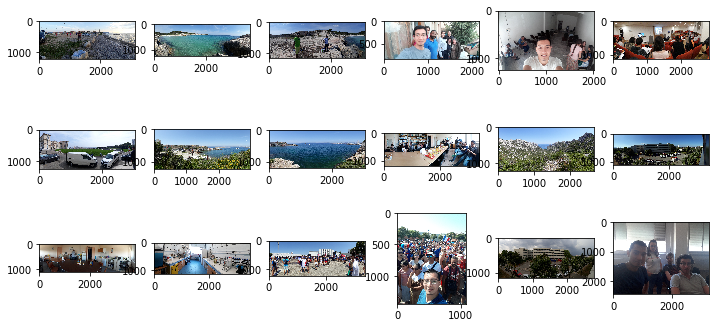

In [3]:
# One folder with all images to sort :
# “One Folder to rule them all, One Folder to find them, 
# One Folder to bring them all and in the darkness classify them.”  
src_folder = "C:\data\class_unsup\poc2"

def plot_some_images(src_folder, max_images=5):
    # Set up a figure of an appropriate size
    fig = plt.figure(figsize=(12, 16))
    
    img_num = 0
    
    # List of files
    filenames = os.listdir(src_folder)
    
    n_col = 6
    n_row = (len(filenames) // n_col) + 1
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    fig = plt.figure(figsize=(n_col*2 , n_row*2 ))
    
    for i, file in enumerate(filenames):
        
        imgFile = os.path.join(src_folder, file)
        img = Image.open(imgFile)
        img = image_transpose_exif(img)

        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(img)
        
        img_num += 1
         
        if img_num == max_images : break
    
plot_some_images(src_folder, max_images=18)

# Classification

Following [beleidy/unsupervised-image-clustering](https://github.com/beleidy/unsupervised-image-clustering/blob/master/capstone.ipynb) capstone project, we will infer 3 different models to our images to ge the features present in our images. We then use PCA for dimension reduction purposes and finally we implement a clustering algorithm to make clusters of images by similarity.

## Preprocess and Normalize Images

In [4]:
import numpy as np

In [5]:
def resize_image(src_image, size=(128,128), bg_color="white"): 
    from PIL import Image, ImageOps 
    
    # resize the image so the longest dimension matches our target size
    src_image.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new square background image
    new_image = Image.new("RGB", size, bg_color)
    
    # Paste the resized image into the center of the square background
    new_image.paste(src_image, (int((size[0] - src_image.size[0]) / 2), int((size[1] - src_image.size[1]) / 2)))
  
    # return the resized image
    return new_image

In [6]:
def load_and_preprocess_image(path_to_image, size, grey=True):
        # open 
        img = Image.open(path_to_image)
        
        # straighten out :
        img = image_transpose_exif(img)
        
        arr = np.array(img)
        
        # Padding with mean of color calculated on the image
        r = int(np.floor(np.mean(arr[:,:,0])))
        g = int(np.floor(np.mean(arr[:,:,1])))
        b = int(np.floor(np.mean(arr[:,:,2])))
        img = resize_image(img, size, bg_color=(r,g,b))
        
        if grey : 
            img = img.convert('L')
            
            # Convert to numpy arrays
            img = np.array(img, dtype=np.float32)

            # Simulate RGB needed to enter pretrained models
            img = np.expand_dims(img, axis=2)
            img = np.repeat(img, 3, -1)
            
        else :
            # Convert to numpy arrays
            img = np.array(img, dtype=np.float32)

        # Normalise the images
        img /= 255
        return img

def compile_images(src_folder, size=(128,128)):
    
    # loop through the images
    # Load .jpg only
    filenames = [jpg for jpg in os.listdir(src_folder) if jpg.endswith(".jpg")]
    
    # Define empty arrays where we will store our images and labels
    images = []
            
    for file in filenames:
        imgFile = os.path.join(src_folder, file)
        img = load_and_preprocess_image(imgFile, size)
        
        # Now we add it to our array
        images.append(img)

    return np.array(images, dtype=np.float32)

In [7]:
images = compile_images(src_folder)

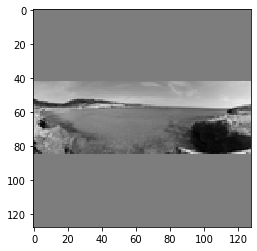

In [8]:
plt.imshow(images[1], cmap="gray")

# Load Model and Make Predictions On Images

## Load Models

In [9]:
import keras
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import time


In [10]:
input_shape=(128,128,3)

resnet50_model = keras.applications.resnet50.ResNet50(include_top=False, weights="imagenet", input_shape=input_shape)
vgg16_model = keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=input_shape)
vgg19_model = keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_shape=input_shape)

In [11]:
def flatten_output(covnet_model, raw_images):
    # Infer the model on raw data
    pred = covnet_model.predict(raw_images)
    # Flatten the prediction array
    flat = pred.reshape(raw_images.shape[0], -1)
    
    return flat

In [12]:
nb_clusters = 3

In [13]:
resnet50_output = flatten_output(resnet50_model, images)
print("ResNet50 flattened output has {} features".format(resnet50_output.shape[1]))

vgg19_output = flatten_output(vgg19_model, images)
print("VGG19 flattened output has {} features".format(vgg19_output.shape[1]))

ResNet50 flattened output has 32768 features
VGG19 flattened output has 8192 features


## PCA Implementation

In [14]:
# Function that creates a PCA instance, fits it to the data and returns the instance
def create_fit_PCA(data, n_components=None):
    p = PCA(n_components=n_components, random_state=728)
    p.fit(data)
    return p

# Function to plot the cumulative explained variance of PCA components
def pca_cumsum_plot(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

In [15]:
# Create PCA instances for each covnet output
vgg19_pca = create_fit_PCA(vgg19_output)
resnet50_pca = create_fit_PCA(resnet50_output)

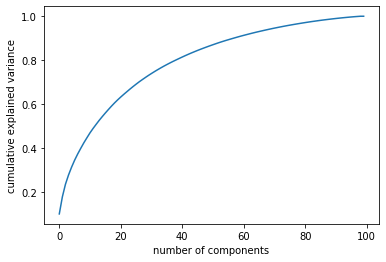

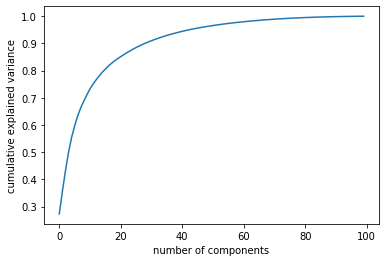

In [16]:
# Plot the cumulative explained variance for each covnet
pca_cumsum_plot(vgg19_pca)
pca_cumsum_plot(resnet50_pca)

In [17]:
vgg19_output_pca = vgg19_pca.transform(vgg19_output)
resnet50_output_pca = resnet50_pca.transform(resnet50_output)

## Clustering Algorithms

In [18]:
# KMEANS
def create_train_kmeans(data, number_of_clusters=nb_clusters):
    
    k = KMeans(n_clusters=number_of_clusters, random_state=728)

    # Let's do some timings to see how long it takes to train.
    start = time.time()

    # Train it up
    k.fit(data)

    # Stop the timing 
    end = time.time()

    # And see how long that took
    print("Training took {} seconds".format(end-start))
    
    return k

In [19]:
# GAUSSIAN MIXTURE
def create_train_gmm(data, number_of_clusters=nb_clusters):
    g = GaussianMixture(n_components=number_of_clusters, covariance_type="full", random_state=728)
    
    start=time.time()
    g.fit(data)
    end=time.time()
    
    print("Training took {} seconds".format(end-start))
    
    return g

In [20]:
def reference_labels (nb_clusters):
    labels = []
    dico = {}
    for i in range(nb_clusters):
        dico[i] = []
    return dico

In [21]:
def group_and_plot(src_folder, clusters, size=(128,128), plot=True, grey=False):
    
    dico = reference_labels(nb_clusters)
    
    filenames = [jpg for jpg in os.listdir(src_folder) if jpg.endswith(".jpg")]
    
    for i, clu in enumerate(clusters):
        dico[clu].append(filenames[i])
        
    if plot :
        
        for clu in dico.keys():
            
            print("************************************************")
            print(f"******************* group {clu} ********************")
            print("************************************************")
            
            n_col = 6
            n_row = (len(dico[clu]) // n_col) + 1
            plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
            fig = plt.figure(figsize=(n_col*3 , n_row*3 ))
            
            for i, file in enumerate(dico[clu]):
                imgFile = os.path.join(src_folder, file)
                
                img = load_and_preprocess_image(imgFile, size, grey)
                                
                plt.subplot(n_row, n_col, i + 1)
                plt.imshow(img)

            plt.show()
                
    return dico

In [22]:
print("\n FIT DATA \n")

# Here we create and fit a KMeans model with the PCA outputs
print("\n KMeans (PCA): \n")

K_vgg19_pca = create_train_kmeans(vgg19_output_pca)
K_resnet50_pca = create_train_kmeans(resnet50_output_pca)

# Same for Gaussian Model
print("\n GMM (PCA): \n")

G_vgg19_pca = create_train_gmm(vgg19_output_pca)
G_resnet50_pca = create_train_gmm(resnet50_output_pca)


 FIT DATA 


 KMeans (PCA): 

Training took 0.2673201560974121 seconds
Training took 0.19800257682800293 seconds

 GMM (PCA): 

Training took 0.07998824119567871 seconds
Training took 0.02380657196044922 seconds


In [23]:
# PREDICTIONS
print("CLUSTERING...")
# KMeans with PCA outputs
k_vgg19_pred_pca = K_vgg19_pca.predict(vgg19_output_pca)
k_resnet50_pred_pca = K_resnet50_pca.predict(resnet50_output_pca)

# Gaussian Mixture with PCA outputs
g_resnet50_pred_pca = G_resnet50_pca.predict(resnet50_output_pca)
g_vgg19_pred_pca = G_vgg19_pca.predict(vgg19_output_pca)

print("CLUSTER DATA GENERATED")

CLUSTERING...
CLUSTER DATA GENERATED


In [24]:
display_size = (56,56)

## Best result

**vgg19** pretrained model followed by **kmeans clustering** achieved some sort of clustering : 
* group 0 : closed places (indoors or dark)
* group 1 : open places (outdoors, landscapes)
* group 2 : people (mostly pictures featuring people)

However, this is a subjective apreciation. An improvement would consist in exploring object identification techniques like yolo. And have a clustring method with information as objects present in the image

************************************************
******************* group 0 ********************
************************************************


<Figure size 432x288 with 0 Axes>

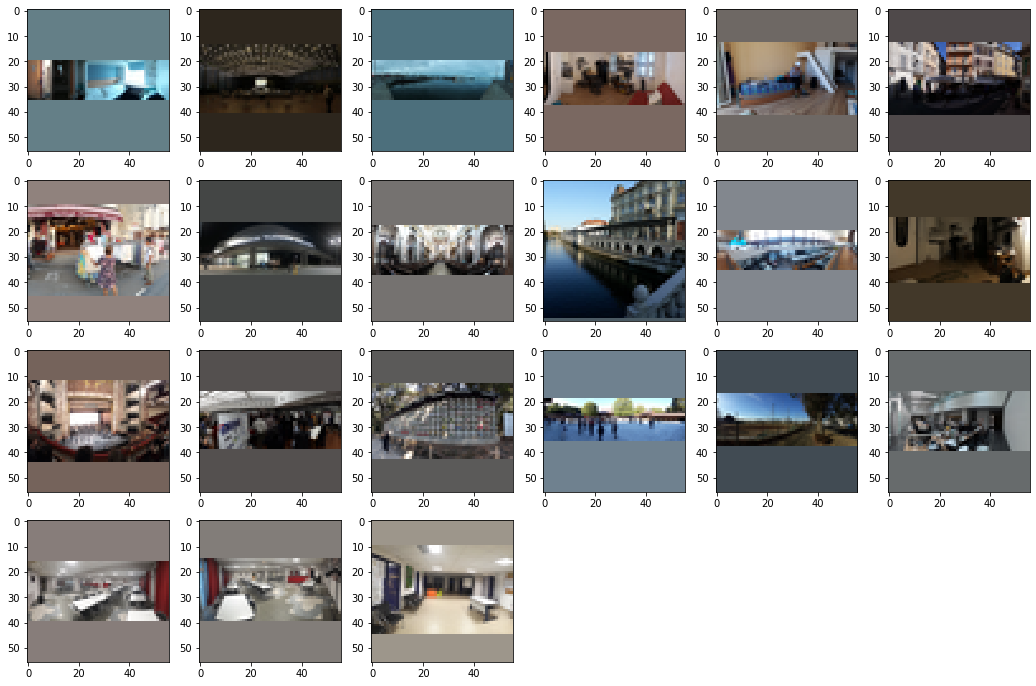

************************************************
******************* group 1 ********************
************************************************


<Figure size 432x288 with 0 Axes>

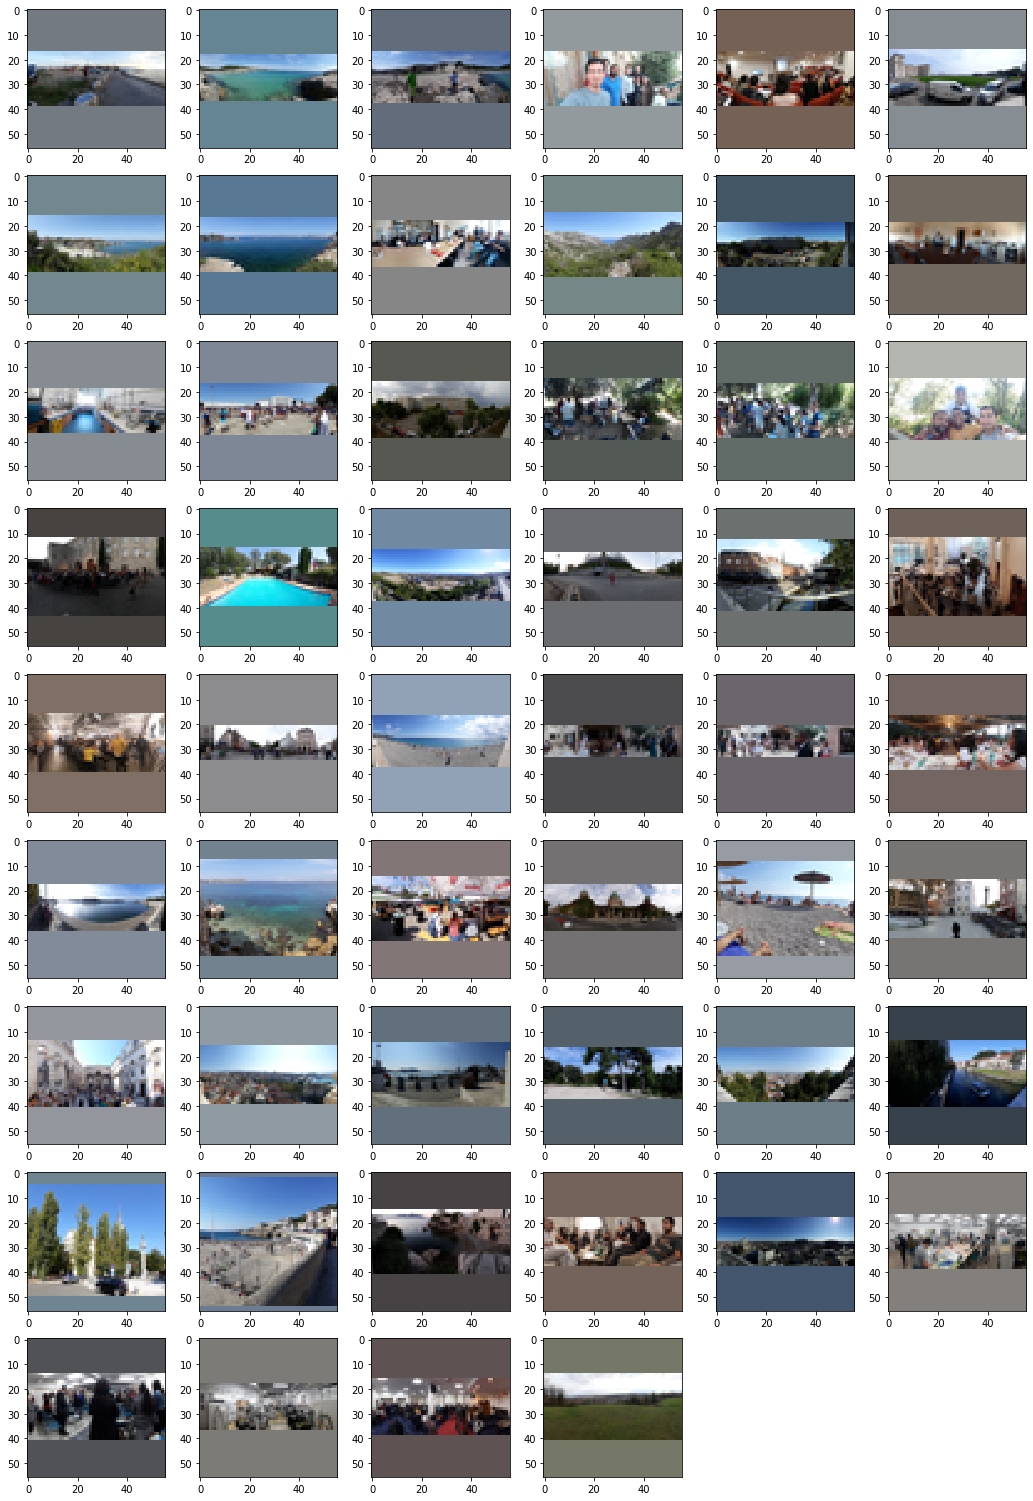

************************************************
******************* group 2 ********************
************************************************


<Figure size 432x288 with 0 Axes>

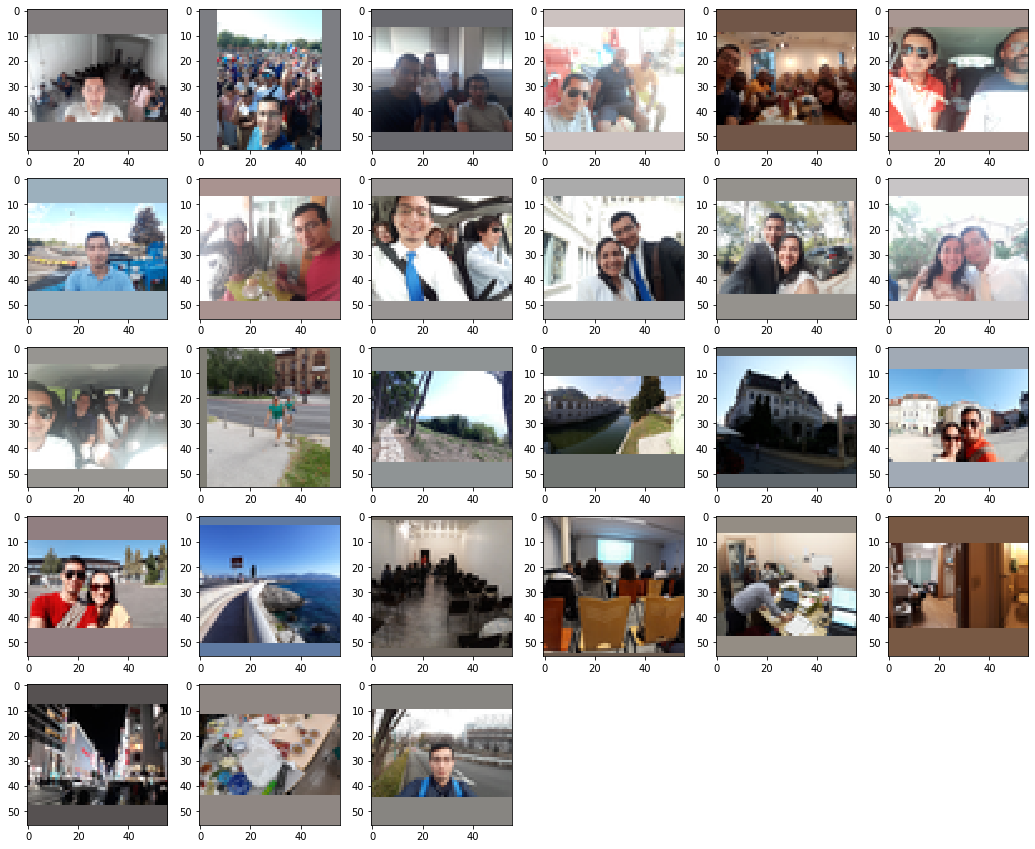

In [25]:
k_vgg19_pred_pca_sorted_filenames = group_and_plot(src_folder, k_vgg19_pred_pca, size=display_size, plot=True)

************************************************
******************* group 0 ********************
************************************************


<Figure size 432x288 with 0 Axes>

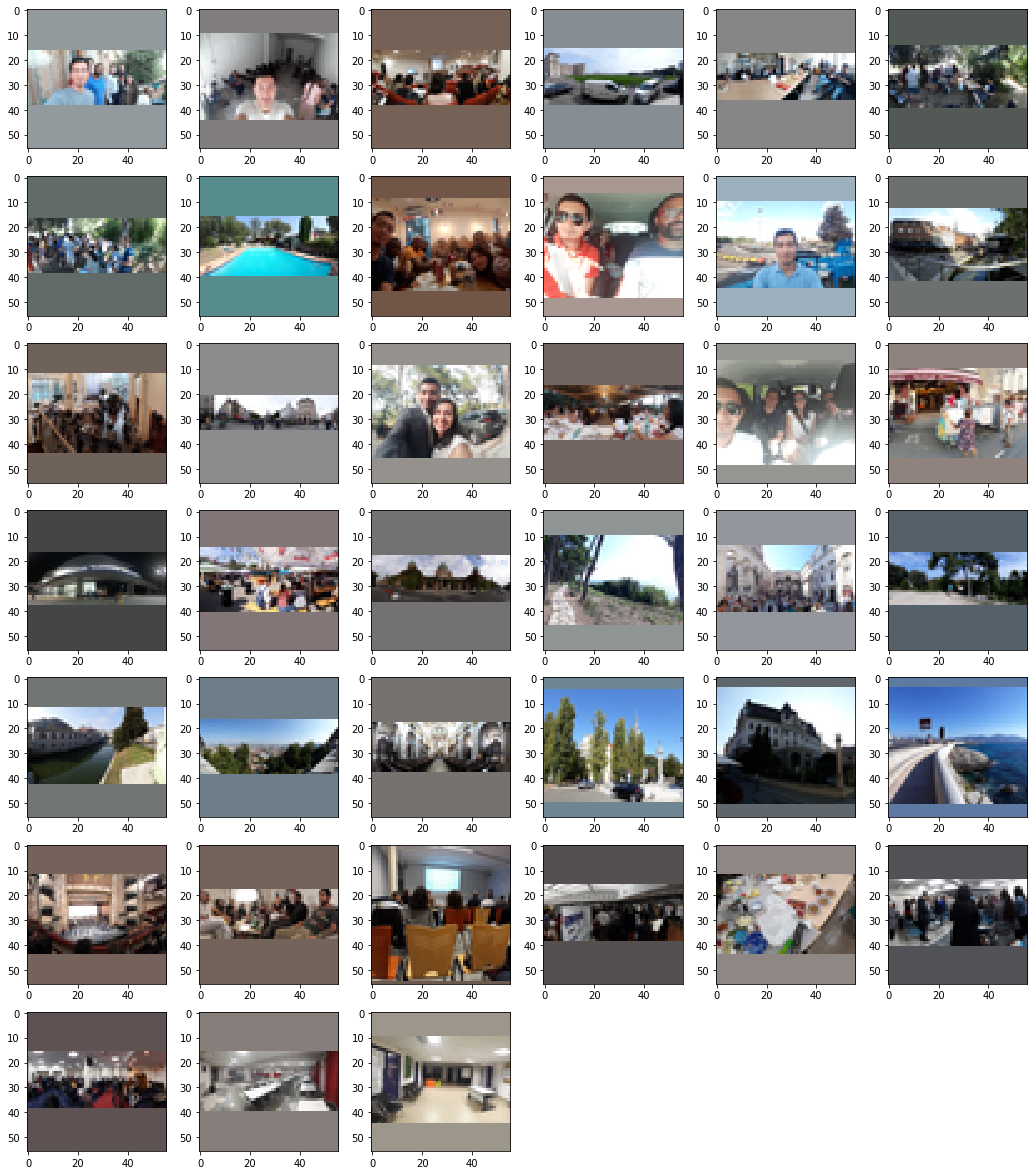

************************************************
******************* group 1 ********************
************************************************


<Figure size 432x288 with 0 Axes>

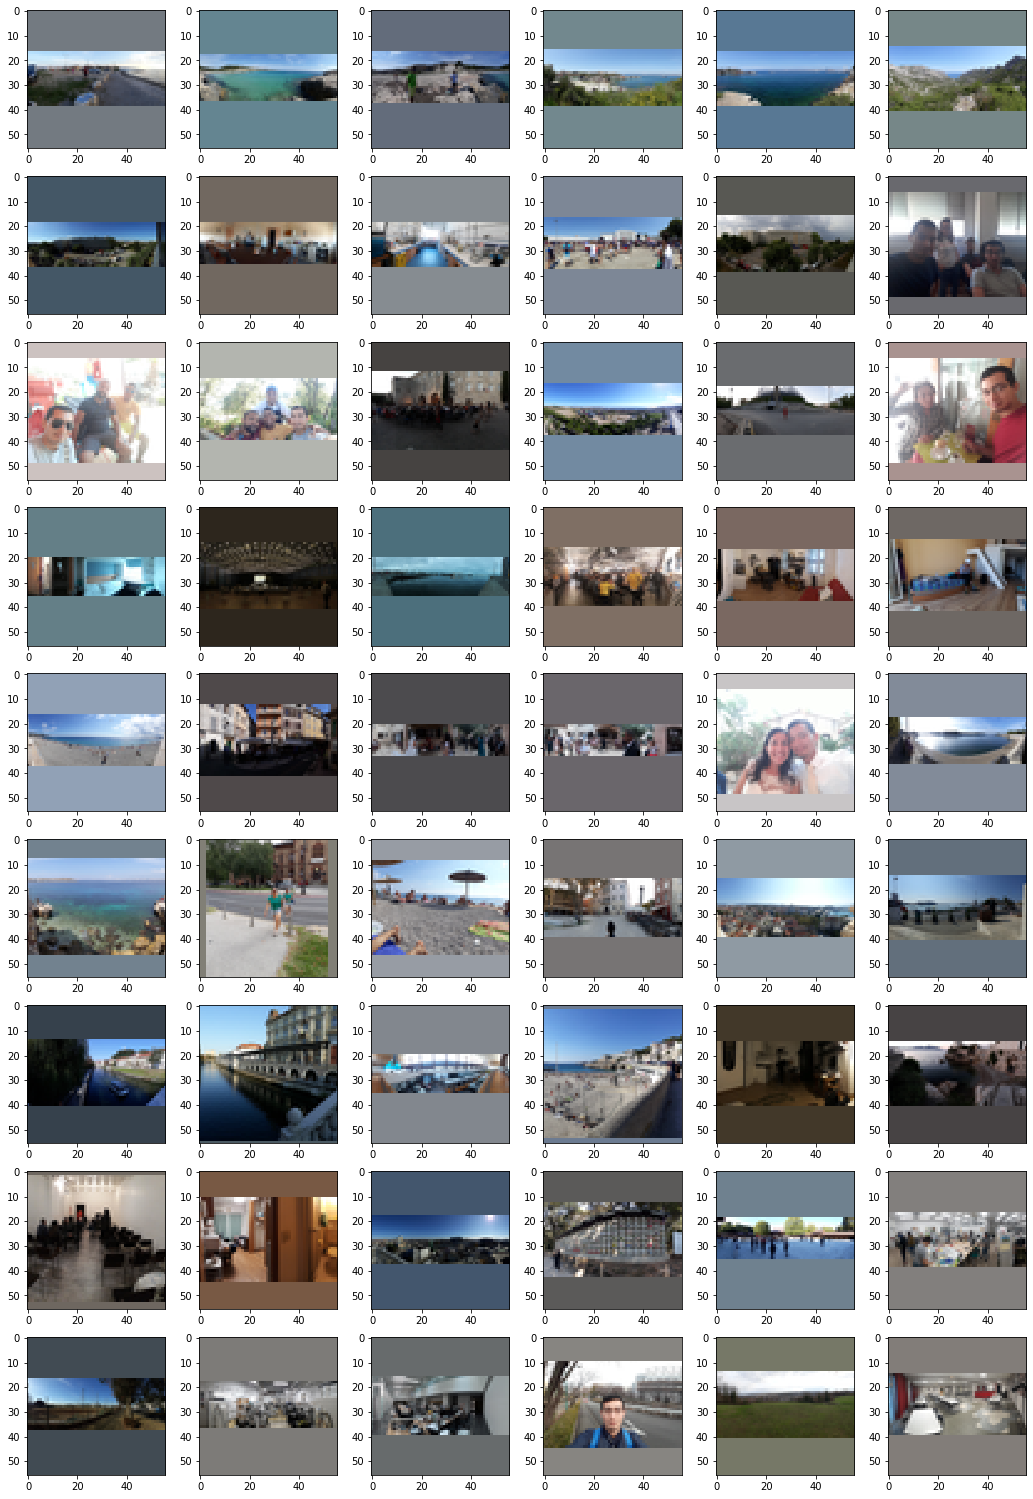

************************************************
******************* group 2 ********************
************************************************


<Figure size 432x288 with 0 Axes>

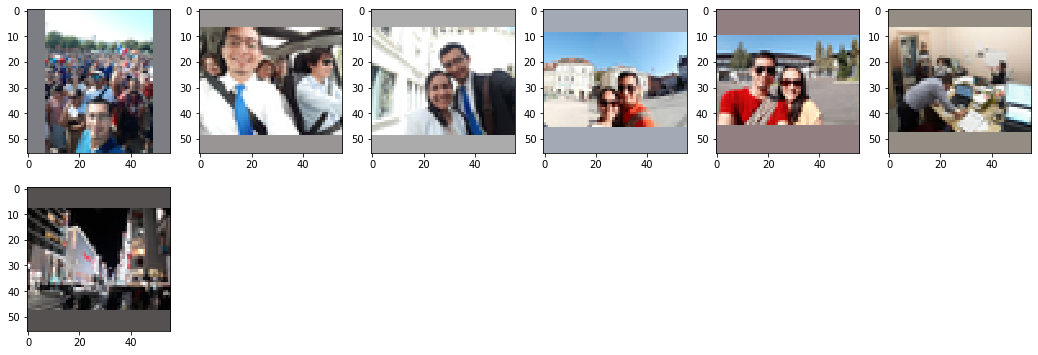

In [26]:
k_resnet50_pred_pca_sorted_filenames = group_and_plot(src_folder, k_resnet50_pred_pca, size=display_size, plot=True)

************************************************
******************* group 0 ********************
************************************************


<Figure size 432x288 with 0 Axes>

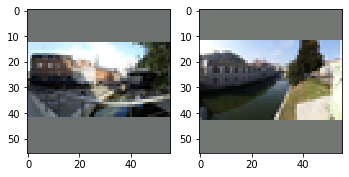

************************************************
******************* group 1 ********************
************************************************


<Figure size 432x288 with 0 Axes>

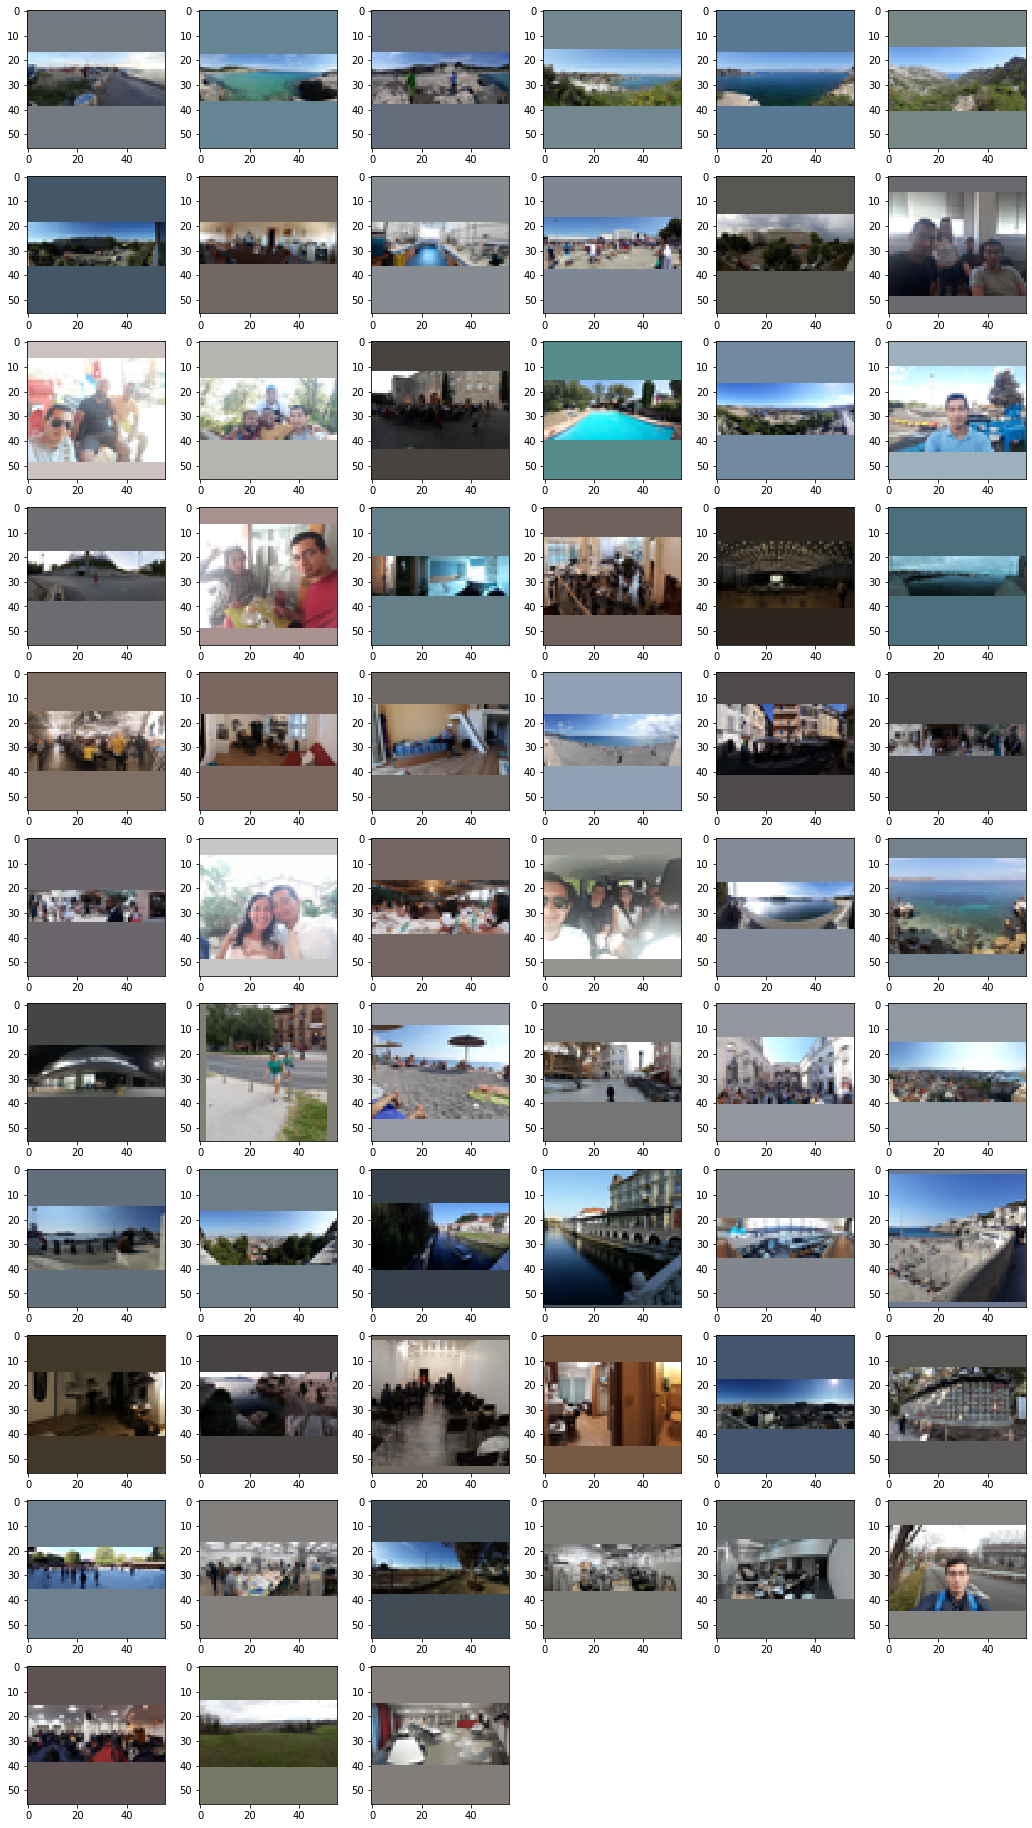

************************************************
******************* group 2 ********************
************************************************


<Figure size 432x288 with 0 Axes>

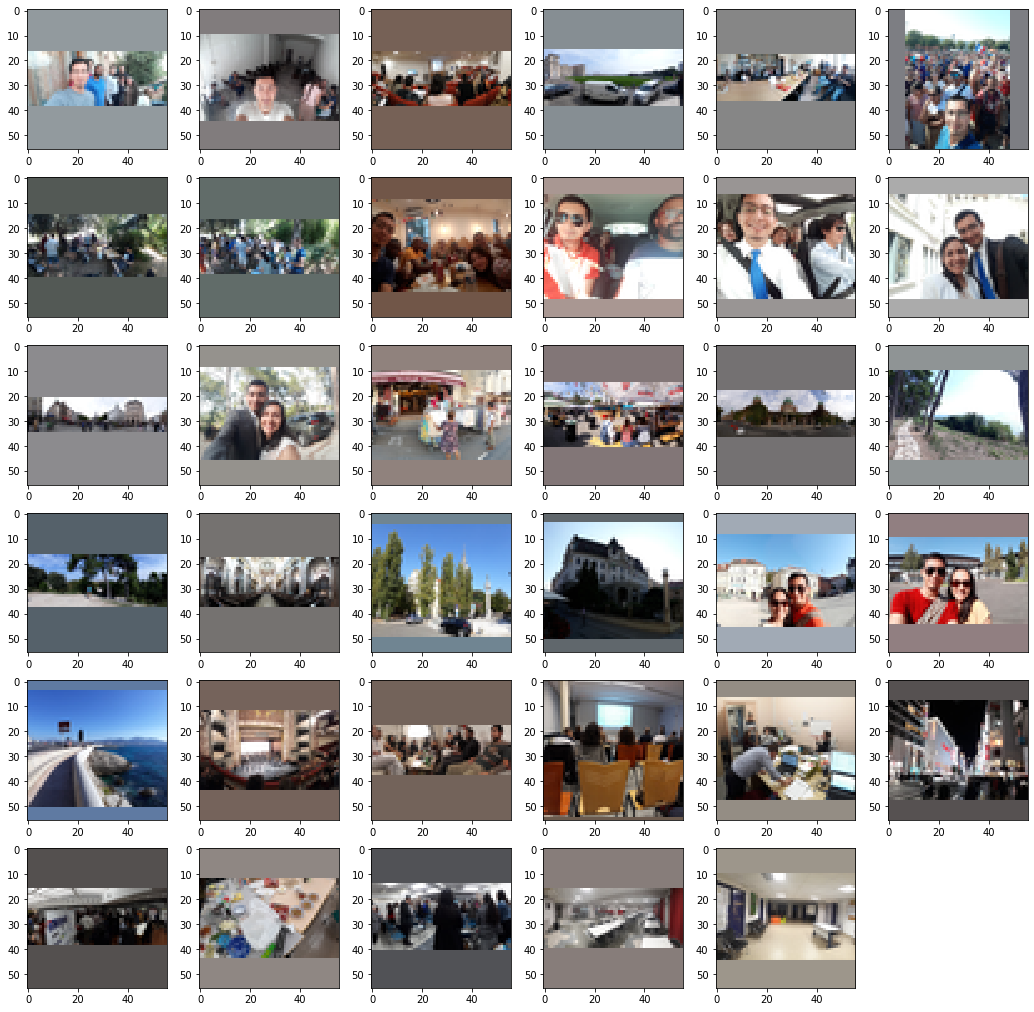

In [27]:
g_resnet50_pred_pca_filenames = group_and_plot(src_folder, g_resnet50_pred_pca, size=display_size, plot=True)

************************************************
******************* group 0 ********************
************************************************


<Figure size 432x288 with 0 Axes>

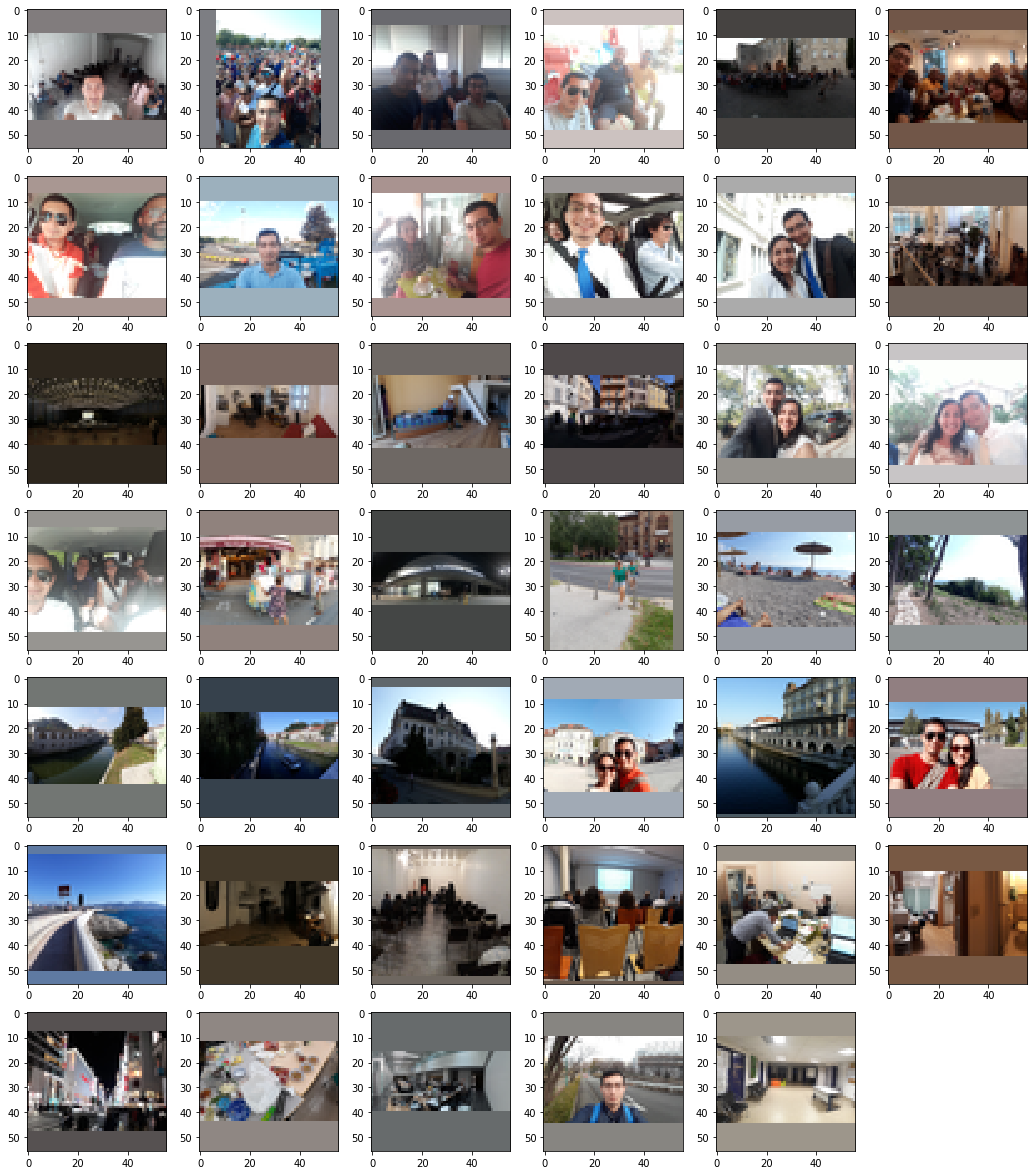

************************************************
******************* group 1 ********************
************************************************


<Figure size 432x288 with 0 Axes>

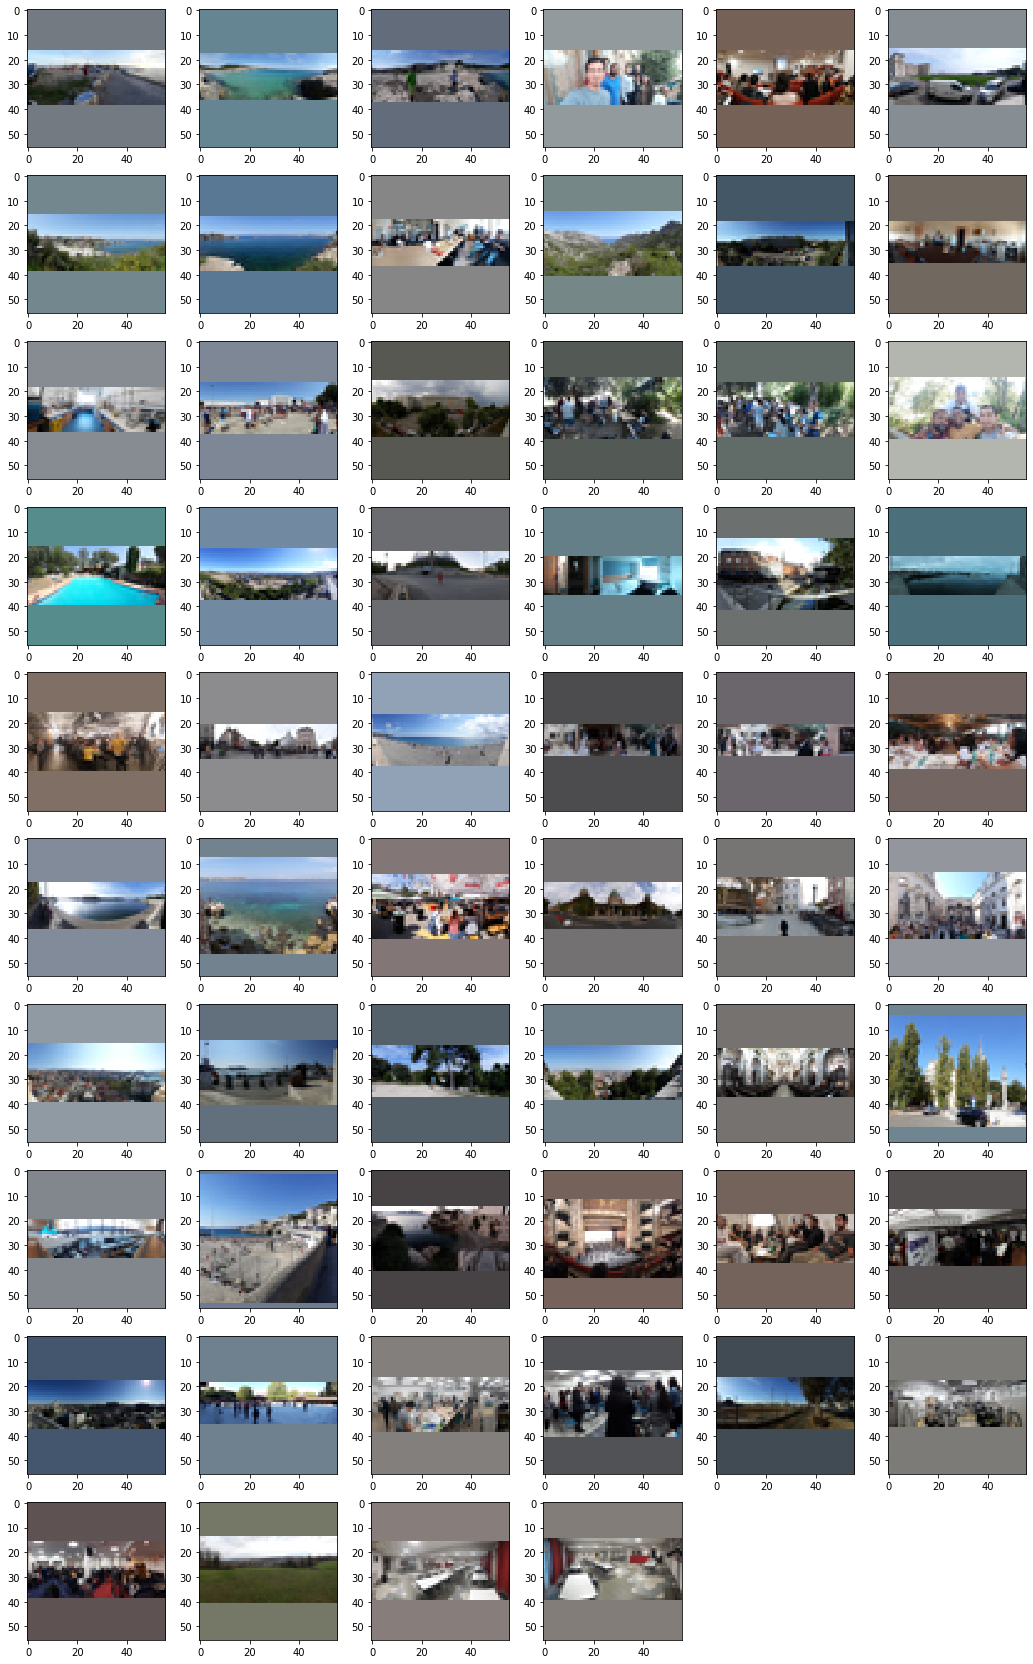

************************************************
******************* group 2 ********************
************************************************


<Figure size 432x288 with 0 Axes>

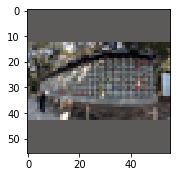

In [28]:
g_vgg19_pred_pca_filenames = group_and_plot(src_folder, g_vgg19_pred_pca, size=display_size, plot=True)